# Soumission

On soumet les prédictions du modèle avec le stacking.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# On définit les modèles de base avec les meilleurs hyperparamètres
random_forest = RandomForestClassifier(
    n_estimators=300,  
    max_depth=None,      
    random_state=42,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
)

xgboost = XGBClassifier(
    colsample_bytree=0.9284956459967804,
    gamma=0.04924511492281908,
    learning_rate=0.24122412239323296,
    max_depth=9,
    n_estimators=300,
    subsample=0.9833984902058166,
    objective='multi:softmax',
    num_class=7,
    random_state=42
)

lightgbm = LGBMClassifier(
    colsample_bytree=0.9488048655607615,
    learning_rate=0.09224159033088929,
    max_depth=15,
    n_estimators=300,
    num_leaves=100,
    subsample=0.5190158468602316,
    objective='multiclass',
    num_class=7,
    random_state=42,
    verbosity=-1
)

# On définit le méta-modèle (un modèle simple comme la régression logistique)
meta_model = LogisticRegression(max_iter=1000)

# On crée le StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', random_forest),
        ('xgb', xgboost),
        ('lgbm', lightgbm)
    ],
    final_estimator=meta_model,
    cv=5  # Utiliser une validation croisée pour le stacking
)

On va entrainer sur X complet et prédire sur test complet.

In [9]:
y_adj = y - 1

X_test_full = pd.read_csv('test-full.csv')

In [ ]:
# On entraîne le modèle de stacking
stacking_model.fit(X, y_adj)

# On prédit sur l'ensemble de test
y_pred_stack = stacking_model.predict(X_test_full)

y_pred_stack = y_pred_stack + 1

In [ ]:
# On crée un DataFrame avec les Id et les Cover_Type prédits
submission_df = pd.DataFrame({
    'Id': X_test_full['Id'],
    'Cover_Type': y_pred_stack
})

# On sauvegarde le DataFrame en fichier CSV
submission_df.to_csv('submission.csv', index=False)

Comme dans le fichier train.csv, les Cover_type sont en proportion égales, on va regarder nos prédiction du fichier test-full.csv si cela est le cas.


Cover_Type
2    0.438710
1    0.364196
3    0.064074
7    0.048588
6    0.039844
5    0.038417
4    0.006170
Name: count, dtype: float64


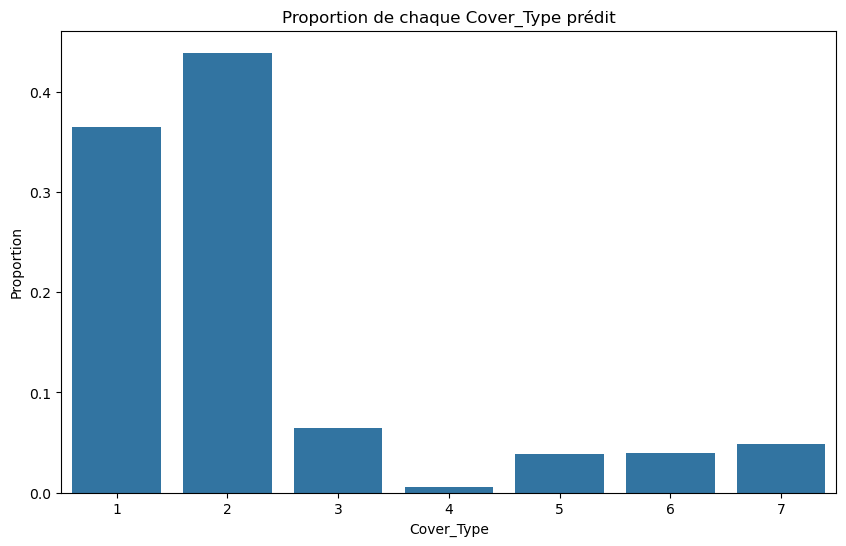

In [14]:
# Compter les occurrences de chaque Cover_Type prédit
cover_type_counts = submission_df['Cover_Type'].value_counts()

# Calculer les proportions
cover_type_proportions = cover_type_counts / len(submission_df)

print(cover_type_proportions)

# On représente les proportions avec un diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=cover_type_proportions.index, y=cover_type_proportions)
plt.xlabel('Cover_Type')
plt.ylabel('Proportion')
plt.title('Proportion de chaque Cover_Type prédit')
plt.show()
